### references
- aspect based sentiment analysis: https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis

### import packages

In [105]:
from utils import data_scraping, absa_english_text
from wordcloud import WordCloud, STOPWORDS
import inflect
import itertools
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pandas as pd
import os

### read & transform data

In [2]:
# read data
file_path = './data/the_grace_dalat_reviews.csv'
try:
    df = pd.read_csv(file_path, converters={'profileId':str})
    eval_cols = ['travelPurpose','travelKeywords','photoDataDisplaysList','reactionSummaries']
    df[eval_cols] = df[eval_cols].applymap(lambda x: eval(x) if isinstance(x, str) else x)
except:
    data = data_scraping(url_hotel="https://www.traveloka.com/vi-vn/hotel/vietnam/the-grace-hotel-dalat-3000010042556", reviews_per_page=10)
    df = data.get_all_reviews()
    df.to_csv(file_path, index=False)

In [3]:
# replace empty data to blank data
df = df.mask(df == '')

# drop columns with no data
df = df.dropna(axis=1, how='all')

# drop rows with no comment
df = df.dropna(subset=['originalReviewText','reviewText'], how='all', axis=0)

# add new columns
df['travelPurposeText'] = df.travelPurpose.apply(lambda x: x['travelPurposeText'] if isinstance(x, dict) else x)
df['travelPurpose'] = df.travelPurpose.apply(lambda x: x['travelPurpose'] if isinstance(x, dict) else x)
df['travelKeywords'] = df.travelKeywords.apply(lambda x: ','.join(sorted(map(lambda y: y['travelKeyword'] if isinstance(y, dict) else '', x))) if isinstance(x, list) else x)
df['reviewLikes'] = df.reactionSummaries.apply(lambda x: x['reactionSummaryMap']['LIKE']['reactionCount'] if isinstance(x, dict) else x)
df['photoCategories'] = df.photoDataDisplaysList.apply(lambda x: ','.join(sorted(map(lambda y: y['photoCategoryDisplay']['photoCategory'] if isinstance(y, dict) else '', x))) if isinstance(x, list) else x)

### aspect-based sentiment analysis
- prioritize the english review text, if none, do the translation

In [4]:
output = []

file_name = './data/output_the_grace_dalat_reviews.csv'
if os.path.exists(file_name):
    df_output = pd.read_csv(file_name)

else:
    output = []
    for id, row in enumerate(df.to_dict(orient='records')):
        reviewTextFn = row['reviewText']
        absa_class = absa_english_text(reviewTextFn)
        if not row['translated']:
            tokenized = absa_class.words_tokenized(teencode_replaced=True)
            reviewTextFn = absa_class.translate_vi_to_en(tokenized)

        reviewTextFn = absa_class.words_tokenized(reviewTextFn, teencode_replaced=False)
        # limit first 400 characters
        reviewTextFn = absa_class.truncate_first_words(reviewTextFn)
        sentiments = absa_class.absa_by_np(reviewTextFn)
        output.append({
            'reviewId': row['reviewId'],
            'sentiment':sentiments
        })
        print(str(id).zfill(3), end=', ')

    df_output = pd.DataFrame(output)
    df_output['sentiment'] = df_output.apply(lambda x: pd.DataFrame(x.sentiment).assign(reviewId = x.reviewId) , axis=1)
    df_output = pd.concat(df_output.sentiment.tolist())
    df_output.to_csv(file_name, index=False)

In [ ]:
# remove STOPWORDS

df_output['aspect'] = df_output.aspect.apply(lambda x: ' '.join([w for w in x.split(' ') if w.lower() not in STOPWORDS])).str.strip()
df_output = df_output.query("aspect.str.len() > 0")

# get the singular form of aspects
p = inflect.engine()
df_output['singular_aspect'] = df_output.aspect.apply(lambda x: p.singular_noun(x) if p.singular_noun(x) != False and nltk.pos_tag([x])[0][1] == 'NNS' else x)

# get the part of speech of aspects
df_output['aspect_pos'] = df_output.singular_aspect.apply(lambda x: nltk.pos_tag([x])[0][1])

# consider to remove non-NN aspects
df_output.query("aspect_pos != 'NN' ").groupby('singular_aspect', as_index=False).agg(reviews=('reviewId','nunique')).sort_values('reviews', ascending=False)

In [63]:
# only keep NN aspects
df_output['clean_aspect'] = df_output.apply(lambda x: x.singular_aspect.lower() if x.aspect_pos == 'NN' else None, axis=1)

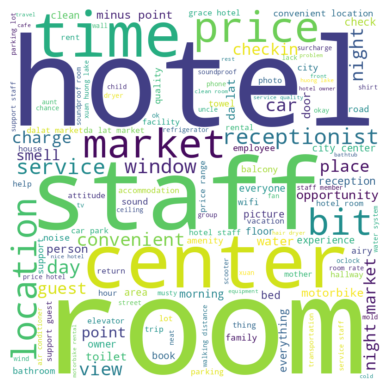

In [76]:
# use wordcloud to highlight the most mentioned keywords
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS, min_font_size=10)
wordcloud.generate_from_frequencies(df_output.clean_aspect.value_counts().to_dict())

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [100]:
sns.color_palette(n_colors=3)[2]

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)

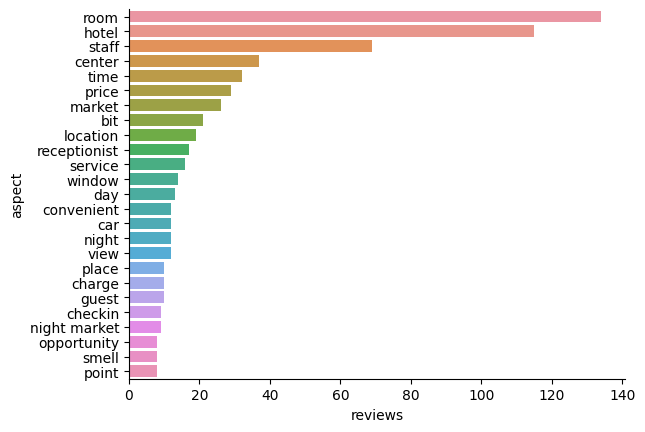

In [98]:
# show top 25 of the most mentioned aspects
ax = plt.subplot(111)
sns.barplot(data=df_output.groupby('clean_aspect', as_index=False)['reviewId'].count().sort_values('reviewId', ascending=False).head(25), x='reviewId', y='clean_aspect', ax=ax)

ax.set_ylabel('aspect')
ax.set_xlabel('reviews')
ax.spines[['top','right']].set_visible(False)

In [102]:
# more than 450 aspects but there are still many irrelevant ones
df_output.nunique()

text                227
aspect              527
sentiment             3
neu_score          1393
neg_score          1393
pos_score          1387
reviewId            227
singular_aspect     497
aspect_pos            9
clean_aspect        458
dtype: int64

In [130]:
# let's try to categorize them into valuable groups
aspect_dictionary = {
    'employee': ['employee','staff','receptionist','manager','workforce','personnel','team','attitude','behavior','proficiency'],
    'nearby facilities':['atm','banking','gift shop','grocery','salon','supermarket','beach','moutain'],
    'hotel services':['laundry','luggage','tours'],
    'in-room facilities':['room','television','desk','minibar','shower','toilet','hygiene','sanitation'],
    'public facilities':['elevator','lift','wifi'],
    'transportation':['parking'],
}
aspect_dictionary_tp = {sub_cat: cat for cat in aspect_dictionary.keys() for sub_cat in aspect_dictionary[cat]}

In [131]:
nlp_lg = spacy.load('en_core_web_lg')
def aspects_similarity(pair, model):
  pair_str = ' '.join(pair)
  tokens = model(pair_str)
  token1, token2 = tokens[0], tokens[1]
  if token1.is_oov or token2.is_oov:
    return 0
  else:
    return token1.similarity(token2)

aspects = df_output.clean_aspect.dropna().unique().tolist()
aspect_cat = list(aspect_dictionary.keys())
aspect_subcat = list(aspect_dictionary_tp.keys())
aspect_grs = [aspect_cat, aspect_subcat]
for aspect_gr in aspect_grs:
  aspect_pairs_similarity_higher_70 = filter(lambda x: aspects_similarity(x, nlp_lg) >= 0.7, itertools.product(aspects, aspect_gr))
  aspects_similarity_higher_70 = len({pair[0] for pair in aspect_pairs_similarity_higher_70})
  print('aspect clusters:', aspect_gr)
  print('aspect similarity lower than 70/100:', "{:.0%}".format((1 - aspects_similarity_higher_70 / len(aspects))))
print(30*'-')

aspect clusters: ['employee', 'nearby facilities', 'hotel services', 'in-room facilities', 'public facilities', 'transportation']
aspect similarity lower than 70/100: 98%
aspect clusters: ['employee', 'staff', 'receptionist', 'manager', 'workforce', 'personnel', 'team', 'attitude', 'behavior', 'proficiency', 'atm', 'banking', 'gift shop', 'grocery', 'salon', 'supermarket', 'beach', 'moutain', 'laundry', 'luggage', 'tours', 'room', 'television', 'desk', 'minibar', 'shower', 'toilet', 'hygiene', 'sanitation', 'elevator', 'lift', 'wifi', 'parking']
aspect similarity lower than 70/100: 96%
------------------------------


In [142]:
aspect_pairs_similarity = [ x + (aspects_similarity(x, nlp_lg),) for x in itertools.product(aspects, aspect_subcat)]
df_aspect_pairs = pd.DataFrame(aspect_pairs_similarity, columns=['aspect','aspect_subcat','similarity'])
df_aspect_pairs = df_aspect_pairs.sort_values(['aspect','similarity'], ascending=[True,False]).drop_duplicates(subset='aspect', keep='first')
df_aspect_pairs['aspect_cat'] = df_aspect_pairs.aspect_subcat.map(aspect_dictionary_tp)

In [154]:
df_aspect_pairs.aspect_cat.value_counts() #query("similarity < 0.5")

employee              271
in-room facilities     80
nearby facilities      39
hotel services         24
public facilities      23
transportation         21
Name: aspect_cat, dtype: int64

In [155]:
df_aspect_pairs.query("aspect_cat == 'in-room facilities' ")

,aspect,aspect_subcat,similarity,aspect_cat
6034,accommodation,sanitation,0.690829,in-room facilities
13258,air,shower,0.349706,in-room facilities
1044,airy,room,0.360748,in-room facilities
13954,attention,sanitation,0.512358,in-room facilities
4876,baby,shower,0.346602,in-room facilities
...,...,...,...,...
7681,wall,shower,0.444867,in-room facilities
7743,wardrobe,room,0.425875,in-room facilities
1444,water,shower,0.484653,in-room facilities
12994,wind,shower,0.359161,in-room facilities
